In [4]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Osm_extraction").getOrCreate()

In [11]:
%run ./00_taa_prep_funcs.ipynb
%run ./00_taa_urbanicity_funcs.ipynb

# 1. Load input data

In [6]:
# 1) Trade area analysis input data
combo_set = expand_combo_set(read_geojson(path="C:/Users/Salif SAWADOGO/OneDrive - EQUATORIAL COCA-COLA BOTTLING COMPANY S.L/dynamic segmentation/urbanicty/output taa combo/", file_name="taa_combo_set_1250.json")) 

# 2. Derive density

In [7]:
urba_set = derive_density(combo_set, ["osm_count", "carto_pop_sum", "carto_pb_urban_poi_count", "carto_mobility_residents_total_sum", "carto_mobility_workers_total_sum", "carto_mobility_others_total_sum"])

# combo_set["ADM_EN"]

# 3. Derive urbanicity


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

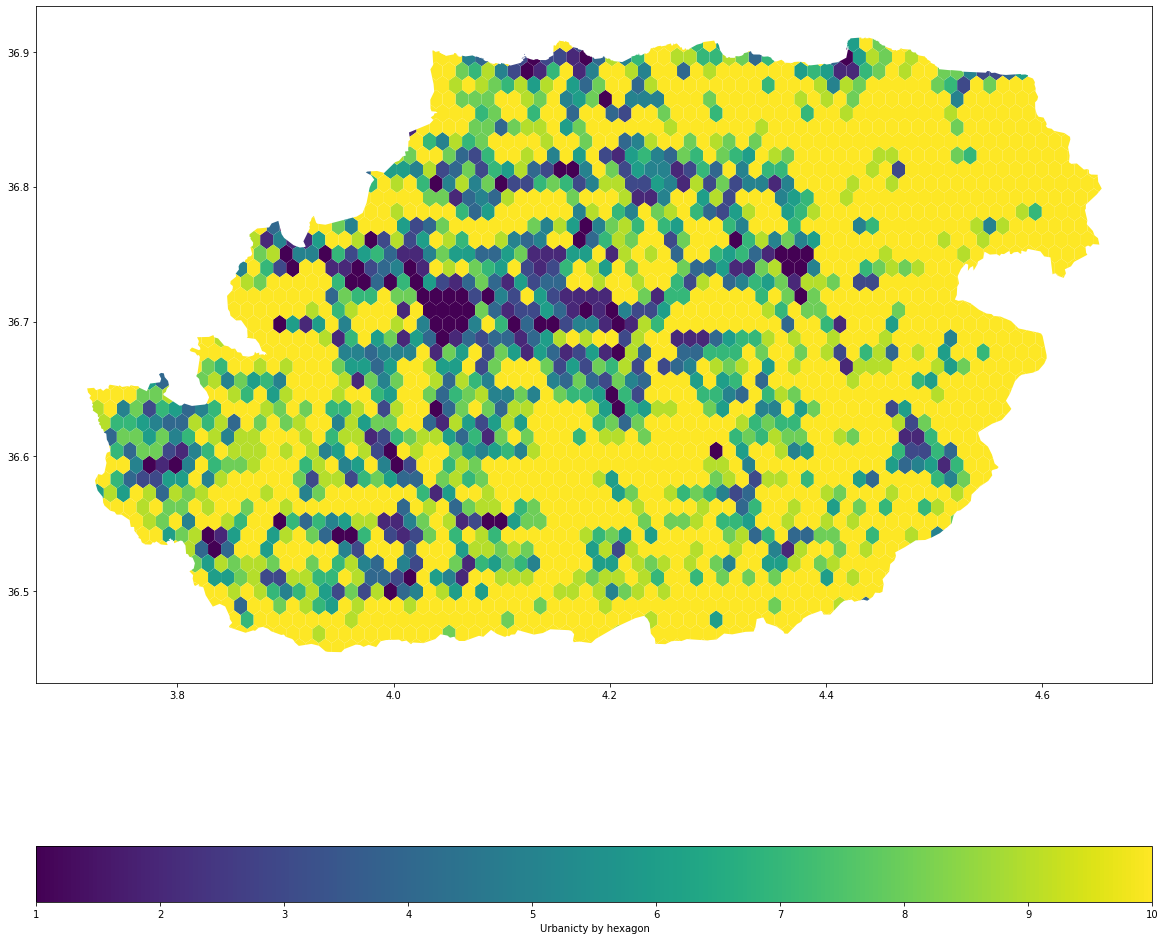

In [14]:
urba_set["overall_score"] = urba_set[["carto_pop_score", "carto_pb_urban_poi_score", "carto_mobility_residents_total_score", "carto_mobility_workers_total_score", "carto_mobility_others_total_score"]].mean(axis=1)
urba_set= \
  derive_urbanicity_with_filler(  
    urba_set, 
    urb_bin_num=10, 
    metric=["overall_score"], 
    pop_metric="carto_pop_sum"  
    , filler=0.00001
  )  
urba_set.loc[3117,"urbanicity_overall"]=10
hex_plot(geo_data=urba_set, metric='urbanicity_overall')

#  3. Derive trade area distance

In [17]:
# Form the combined GeoDataFrame with data on territory, hexagons, population, osm, urbanicity, cmd and trade area distance
# runtime: 5 min
 
trade_area = derive_taa_dist__(path_cmd="D:/data_quality/data", cmd_set="customer_invoice_tizi_ouzou.xlsx",   # latest set: 200706_100000_cmd.csv
  urba_set = urba_set,path_hex="D:/data_quality/data", taa_set="taa"
)
trade_area["urbanicity_overall"] = trade_area["urbanicity_overall"].apply(int)

In [18]:

ta_groupby = trade_area[["CHANNEL_CUSTOM", "urbanicity_overall", "dist_km"]].groupby(["CHANNEL_CUSTOM", "urbanicity_overall"], as_index=False)
ta_mean = ta_groupby.mean().rename(columns={"dist_km": "TA_radius"})
ta_count = ta_groupby.count().rename(columns={"dist_km": "nr_outlets"})
ta_table = ta_mean.merge(ta_count).rename(columns={"urbanicity_overall": "urbanicity"})
ta_table

,CHANNEL_CUSTOM,urbanicity,TA_radius,nr_outlets
0,AG,1,0.129763,1415
1,AG,2,0.917349,251
2,AG,3,1.081934,231
3,AG,4,1.500721,182
4,AG,5,2.179730,116
5,AG,6,2.719648,119
6,AG,7,3.719770,75
7,AG,8,3.753641,68
8,AG,9,5.058635,58
9,AG,10,7.239992,36


plot a multilayer plot of the combined metric

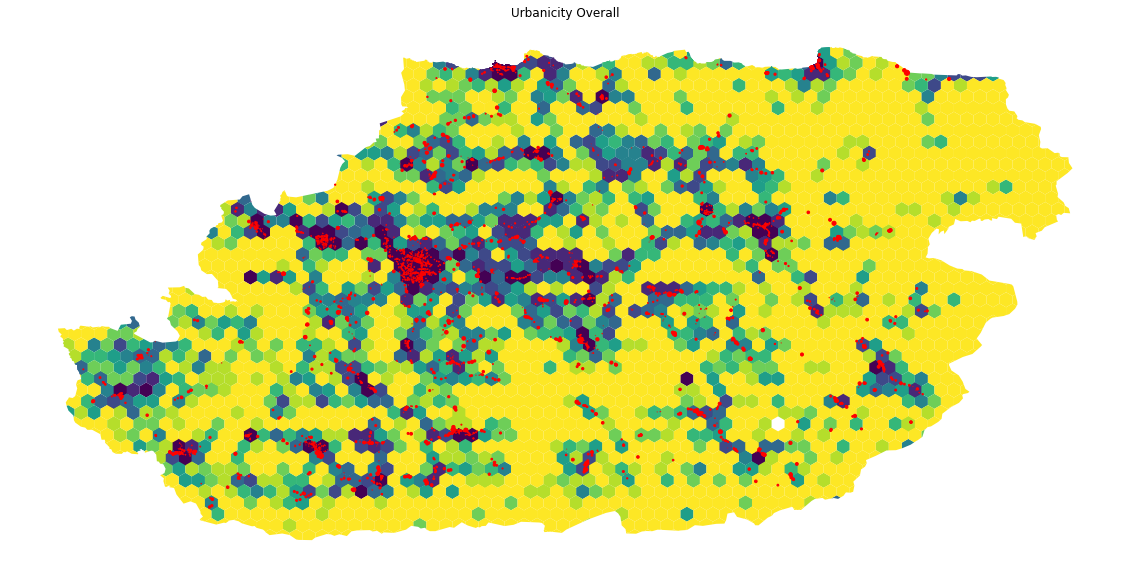

In [19]:
hex_outlet_plot(
  hex_set=urba_set, 
  hex_metric='urbanicity_overall',
  point_set=trade_area.loc[:, ['geometry', 'LONGITUDE', 'LATITUDE', 'cmd_geometry', 'dist_km']],  
  point_metric='cmd_geometry', 
  point_size='dist_km')

Form a subset and plot a multilayer plot of the combined metric

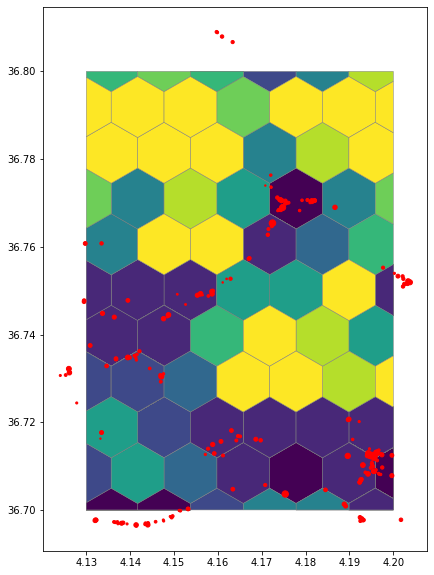

In [20]:
hex_outlet_plot_(
  hex_set=urba_set, 
  hex_metric='urbanicity_overall',
  point_set=trade_area.loc[:, ['geometry', 'LONGITUDE', 'LATITUDE', 'cmd_geometry', 'dist_km']],  
  point_metric='cmd_geometry', 
  point_size='dist_km')